<a href="https://colab.research.google.com/github/djliden/deep_learning_practice/blob/main/notebooks/Collaborative%20Filtering%20Book%20Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background
This is the second version of this notebook. In the first passthrough, I noticed that the rating scale ranged from 0 to 11, but did not think 0 had any special meaning. However, unpon exploring the book crossing website further, I found that 0 constituted an "implicit rating" where a user bought and/or read the book but did not actually leave a rating. In this version of the notebook, I will be excluding observations with a rating of 0.

# Book Recommendation Dataset
In this notebook, I attempt to reproduce the recommendation engine from chapter 8 using the [Book-Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/).

Source: *Improving Recommendation Lists Through Topic Diversification*,
Cai-Nicolas Ziegler, Sean M. McNee, Joseph A. Konstan, Georg Lausen; Proceedings of the 14th International World Wide Web Conference (WWW '05), May 10-14, 2005, Chiba, Japan. To appear.



In [1]:
%%capture
!pip install --upgrade fastai

Note the use of the `%%capture` tag -- this prevents the cell from printing the output, which is long and not particularly useful when simply reinstalling/upgrading fastai at the beginning of a colab session.

## Downloading and Exploring the Data
We will be following the same general process as in chapter 8 using the "Book-Crossing" dataset. Book-Crossing is a website for "releasing your books 'into the wild' for a stranger to find." I didn't actually see book ratings on their website, so I don't have any additional details on the rating system used.

In [2]:
# Data Source http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip
from fastai.collab import *
from fastai.tabular.all import *
import pandas as pd

path = untar_data("http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip")

Note that, in this case, our unzipped data do *not* end up in their own separate directory but are unzipped directly into `~/.fastai/data` (the default location for `untar_data`. So to access the unzipped files, we need to look in `path.parent` as the default `untar_data` options (apparently) assume that a new directory is created. 

In [14]:
bookratings = pd.read_csv(path.parent / 'BX-Book-Ratings.csv', sep=';', encoding = "ISO-8859-1")
booknames = pd.read_csv(path.parent / 'BX-Books.csv', sep=';', encoding = "ISO-8859-1",
                       quotechar='"', escapechar='\\', usecols=(0,1,2))

Parsing the data took some work as several of the fields have quotes or semicolons. Semicolons are the separator for these `csv`s and quotes mark text fields, so we need to make sure that these characters are handled appropriately when they appear within fields. I also needed to specify the encoding, though I can't say with any certainty why that particular encoding worked. It was in a stackexchange answer.

In [4]:
bookratings.head(), bookratings.shape

(   User-ID        ISBN  Book-Rating
 0   276725  034545104X            0
 1   276726  0155061224            5
 2   276727  0446520802            0
 3   276729  052165615X            3
 4   276729  0521795028            6,
 (1149780, 3))

This is quite a bit bigger than the MovieLens subset we worked through in chapter 8, with 1.15 million ratings.

In [5]:
bookratings.nunique()

User-ID        105283
ISBN           340556
Book-Rating        11
dtype: int64

So we have more than 100,000 unique users and more than 340,000 unique books. We also have 11 ratings, on a 0 through 10 scale.

In [6]:
np.sort(bookratings['Book-Rating'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [17]:
sum(bookratings['Book-Rating']==0)

716109

That's huge -- well over half of the ratings are 0 ("implicit" ratings). Let's drop them and see what happens.

In [18]:
bookratings = bookratings[bookratings['Book-Rating']!=0]

In [21]:
np.sort(bookratings['Book-Rating'].unique()), bookratings.shape

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), (433671, 3))

So now we're down to about 430,000 ratings.

### Getting Book Titles
We also want a way to figure out the titles of books. These were stored in a separate csv file, which we extracted above. Let's take a look.

In [22]:
booknames['title-author'] = booknames['Book-Title'] + ' (' + booknames['Book-Author'] + ')'
booknames = booknames.drop(['Book-Title', 'Book-Author'],1)
booknames.head()

,ISBN,title-author
0,0195153448,Classical Mythology (Mark P. O. Morford)
1,0002005018,Clara Callan (Richard Bruce Wright)
2,0060973129,Decision in Normandy (Carlo D'Este)
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It (Gina Bari Kolata)
4,0393045218,The Mummies of Urumchi (E. J. W. Barber)


And now we'll merge this into our book ratings dataframe.

In [23]:
books = bookratings.merge(booknames, on='ISBN')
books.head()

,User-ID,ISBN,Book-Rating,title-author
0,276726,0155061224,5,Rites of Passage (Judith Rae)
1,276729,052165615X,3,Help!: Level 1 (Philip Prowse)
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge English Readers) (Sue Leather)
3,276744,038550120X,7,A Painted House (JOHN GRISHAM)
4,11676,038550120X,10,A Painted House (JOHN GRISHAM)


In [25]:
books.shape

(383852, 4)

Now we have our dataframe of users, ratings, and titles. Let's proceed with our collaborative learner.

### Prepare the DataLoaders

In [26]:
dls = CollabDataLoaders.from_df(books,
                                user_name='User-ID',
                                rating_name='Book-Rating',
                                item_name='title-author', bs=64,
                                seed=46)
dls.show_batch()

,User-ID,title-author,Book-Rating
0,139467,Intimate Strangers (Juliette Mead),5
1,9227,Arena (Karen Hancock),7
2,141373,Widow's Walk: One Woman's Spiritual and Emotional Journey to a New Life (Anne Hosansky),10
3,78553,Jungle Tales of Tarzan (Tarzan) (Edgar Rice Burroughs),10
4,111051,Capital Crimes (Lawrence Sanders),4
5,212467,Chicken Soup for the Couple's Soul (Chicken Soup for the Soul) (Jack Canfield),10
6,27317,Blackbird: A Childhood Lost and Found (Jennifer Lauck),7
7,66574,Girlfriend in a Coma (Douglas Coupland),6
8,196118,Angelas Ashes (Frank Mccourt),8
9,109144,Piercing the Darkness (Frank E. Peretti),8


## Fit the First Model

In [27]:
learn = collab_learner(dls, n_factors=50, y_range=(0,10.5))
#learn.lr_find()
learn.fit_one_cycle(5,.1,wd=0.1)

KeyboardInterrupt: 

### QUESTIONS
- How does it know which is the user and which is the item? **Answer:** *Assumes user name is first column, item name is second, and rating is third. Though in this case I just made it explicit.*
- Why does this one take so much longer than the movies dataset? *Number of observations is much larger*
- It doesn't seem to matter that the User-ID isn't any kind of index. Would we need to create an index to redo this in the same manual way as we did with the movie dataset? Or would `embedding` at least take care of that?
- How do we interpret the loss in terms of ratings? Would $\sqrt{MSELossFlat}$ be in terms of the original scale? I.e. does a loss of 13.3 translate to an average ratings miss of about 3.6 (out of 11)?
- Hyperparameter tuning in fastai? More used to e.g. `scikit-learn` pipelines with grid search etc. What is the process here? Especially for something as time and resource intensive as this. 

In [16]:
book_bias = learn.model.i_bias.weight.squeeze()
idxs = book_bias.argsort(descending=True)[:5]
[dls.classes['title-author'][i] for i in idxs]

['Harry Potter and the Goblet of Fire (Book 4) (J. K. Rowling)',
 'Free (Paul Vincent)',
 'Harry Potter and the Prisoner of Azkaban (Book 3) (J. K. Rowling)',
 'The Little Prince (Antoine de Saint-ExupÃ©ry)',
 "Harry Potter and the Sorcerer's Stone (Book 1) (J. K. Rowling)"]

## As a Neural Network

In [17]:
embs = get_emb_sz(dls)
embs

[(81366, 600), (250105, 600)]

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.001737800776027143)

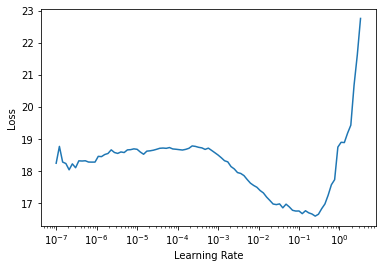

In [18]:
learn = collab_learner(dls, use_nn=True, y_range = (0,10.5), layers=[100,50])
learn.lr_find()

In [19]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,11.548491,11.930031,10:15
1,11.929186,11.840283,10:17
2,11.395682,11.615783,10:17
3,11.385513,11.382813,10:16
4,9.496430,11.972701,10:16


Even after only one epoch, our loss was considerably better. But training took a lot longer. Improvements after the first epoch were relatively modest until the final epoch, where we saw a large drop in the training loss coupled with an increase in the validation loss. So we run this again, but stick with four epochs.

In [22]:
learn = collab_learner(dls, use_nn=True, y_range = (0,10.5), layers=[100,50])
learn.fit_one_cycle(4, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,12.136808,11.854667,10:16
1,12.077656,11.703866,10:16
2,11.253834,11.495584,10:18
3,9.902205,11.723264,10:18


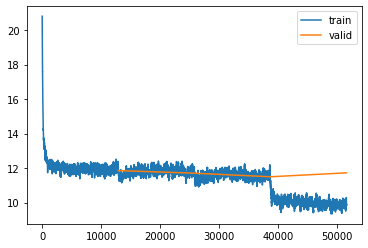

In [24]:
learn.recorder.plot_loss()

And the same thing happened after the third epoch this time, but I really can't take the time or compute expense to do it again!

In [26]:
learn.export()

In [25]:
book_bias = learn.model.
idxs = book_bias.argsort(descending=True)[:5]
[dls.classes['title-author'][i] for i in idxs]

ModuleAttributeError: 'EmbeddingNN' object has no attribute 'i_bias'

Similar. I remain confused by "Free." It doesn't seem to be a paricularly popular or well-known book based on my searching. I found a fairly detailed EDA from a kaggle user [here](https://www.kaggle.com/somnambwl/very-basic-book-recommendations). It found that Free was, indeed, one of the most-rated books, with a high average rating.

At the end of this exercise, my biggest outstanding question is: what is a good process for hyperparameter tuning using `fastai`?

In [ ]:
## Book Similarity

book_factors = learn.model.i_weight.weight
idx = dls.classes['title-author'].o2i["Harry Potter and the Goblet of Fire (Book 4) (J. K. Rowling)"]
distances = nn.CosineSimilarity(dim=1)(book_factors, book_factors[idx][None])
idxs = distances.argsort(descending=True)[1]
dls.classes['title-author'][idxs]

Makes sense. Though to be completely transparent, most of the "book similarities' did *not* make intuitive sense to me.